# Deflection Profile Parametric Study
This file presents a parametric study based on the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
# %matplotlib widget
%matplotlib qt

In [1]:
from bmcs_cross_section.api import MKappa, ReinforcementType, Reinforcement, TShape, EC2
from bmcs_beam.api import BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, LoadDeflectionParamsStudy
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

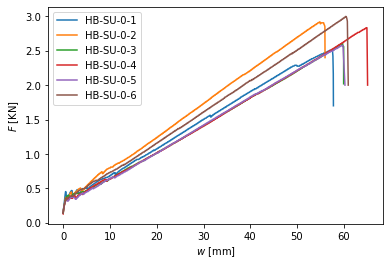

In [3]:
#HB-SU-0
%matplotlib inline
excel_file = join('./verification_data/hei20','hei20.xlsx')
data = pd.read_excel(excel_file, 'HB-SU-0', engine='openpyxl')

for i in range(0,data.shape[1], 2):
    plt.plot(data.iloc[:, i+1],data.iloc[:, i], label = data.columns.tolist()[i][0:-2])
w_4= data['HB-SU-0-4_w']
f_4= data['HB-SU-0-4_F']
exp_data = [w_4, f_4/4]
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')
plt.legend()

In [4]:
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr,
            eps_tu = 9.02/E,
            eps_cy = 72/E,
            eps_cu = (72/E)*2,
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

Parametric study is running...
L: 840, 1260, 
B: 20, 70, 
H: 25, 35, 
E_ct: 29500, 49500, 
E_cc: 29500, 49500, 
eps_cr: 6.3e-05, 0.000263, 
eps_cy: 0.00103, 0.0025, 
eps_cu: 0.002, 0.003, 
eps_tu: 0.00026, 0.00626, 
mu: 0, 1, 
z: 1, 29, 
A: 2.62, 4.62, 
E: 220000, 260000, 
eps_sy: 0.0108, 0.0118, 
n_x: 10, 1000, 
Parametric study finished.


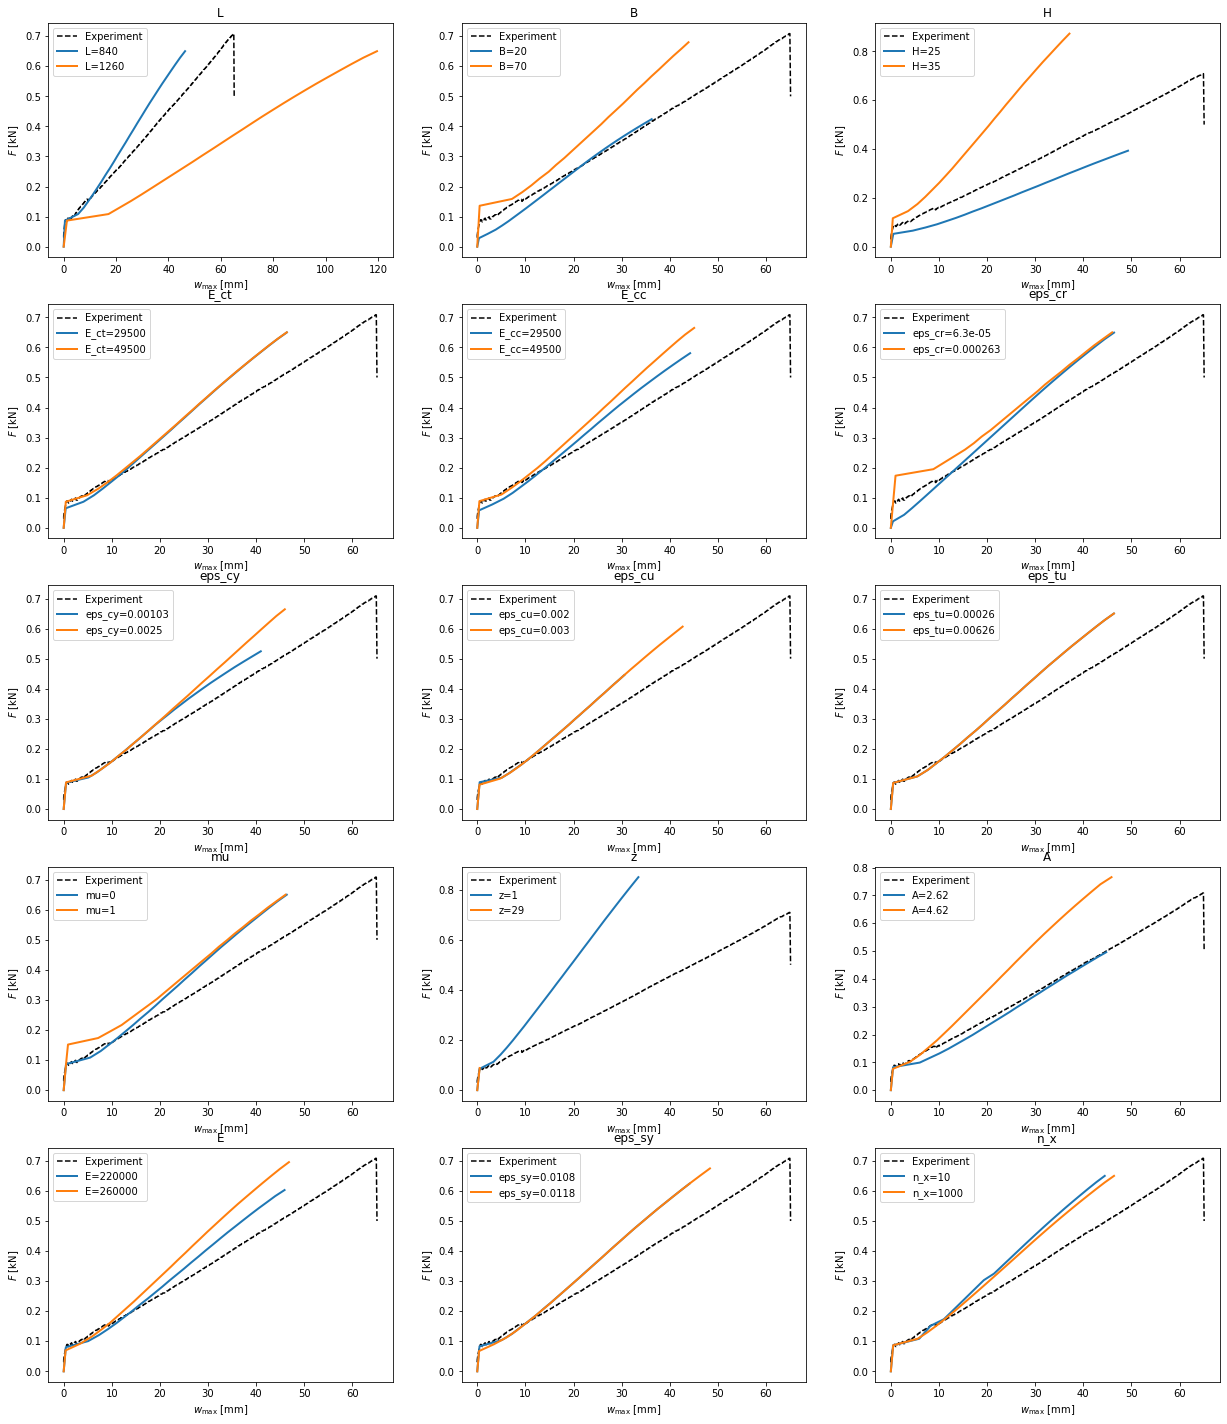

In [5]:
# Or use np.linspace(low, high, n) as the values list for each parameter and change n externally
# gesucht ist Zug- und Druckfestigkeit, E-Modul
params_config = [
#         ['L',      dp.beam_design, [840, 1260]],
#         ['B',      mc.cross_section_shape, [20, 70]],
#         ['H',      mc.cross_section_shape, [25, 35]],
        ['E_ct',   mc, [29500, 49500]],
        ['E_cc',   mc, [29500, 49500]],
        ['eps_cr', mc, [0.000063, 0.000263]],
        ['eps_cy', mc, [0.00103, 0.0025]],
        ['eps_cu', mc, [0.002, 0.003]],
        ['eps_tu', mc, [0.00026, 0.00626]],
        ['mu',     mc, [0, 1]],
        ['z',      mc.cross_section_layout.reinforcement[0], [1, 29]],
        ['A',      mc.cross_section_layout.reinforcement[0], [2.62, 4.62]],
        ['E',      mc.cross_section_layout.reinforcement[0], [220000, 260000]],
        ['eps_sy', mc.cross_section_layout.reinforcement[0], [0.0108, 0.0118]],
        ['n_x',    dp.beam_design, [10, 1000]],
]

LoadDeflectionParamsStudy(dp).run(params_config, exp_data)